<a href="https://colab.research.google.com/github/rexwotan-A01840088/Ciencia-y-Analitica-de-datos/blob/main/Actividad4EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC5053 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 4**
Exploración de datos

---

*   NOMBRE: Rex Wotan Dominguez Chang
*   MATRÍCULA: A01840088

En esta actividad trabajarás con el archivo `personal_loan.csv`, basado en un conjunto de datos sobre clientes bancarios y su comportamiento financiero disponible en Kaggle.

Los datos fueron recopilados para analizar la posibilidad de que los clientes acepten un préstamo personal y contienen información demográfica, financiera y de productos bancarios asociados. Los indicadores incluidos son:

* `ID`: Identificador único del cliente
* `Age`: Edad del cliente (años completos)
* `Experience`: Experiencia laboral en años
* `Income`: Ingreso anual del cliente (en miles de dólares. Por ejemplo, 60 = 60,000 USD/año)
* `ZIP Code`: Código postal del cliente
* `Family`: Número de miembros de la familia
* `CCAvg`: Promedio de gastos mensuales con tarjeta de crédito (en miles de dólares)
* `Education`: Nivel educativo (1 = graduado, 2 = universitario, 3 = posgrado)
* `Mortgage`: Monto de hipoteca que posee el cliente (en miles de dólares)
* `Securities Account`: Indicador de si tiene cuenta de valores (1 = sí, 0 = no)
* `CD Account`: Indicador de si tiene cuenta de certificado de depósito (1 = sí, 0 = no)
* `Online`: Indicador de si usa los servicios bancarios en línea (1 = sí, 0 = no)
* `CreditCard`: Indicador de si es titular de tarjeta de crédito (1 = sí, 0 = no)
* `Personal Loan`: Si el cliente aceptó (1) o no (0) un préstamo personal. Es la variable de salida o *target*, es decir, la que se pretende predecir más adelante al construir el modelo

**NOTA IMPORTANTE:** Asegúrate de responder *explícitamente* todos los cuestionamientos.

In [38]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

1. Descarga el archivo: `personal_loan.csv` y guarda, en un dataframe (`loan_df`), todos sus registros.
* Haz que la columna `ID` sea el índice del dataframe.
* Utiliza el método `info()` del dataframe, para obtener el resumen de los tipos de datos. ¿Cuántas columnas son numéricas y cuántas de texto?

In [39]:
loan_df = pd.read_csv('personal_loan.csv')
loan_df = loan_df.set_index('ID')
loan_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5037 entries, 0 to 5036
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5037 non-null   int64  
 1   Experience          5037 non-null   int64  
 2   Income              5037 non-null   int64  
 3   ZIP Code            5037 non-null   int64  
 4   Family              5037 non-null   int64  
 5   CCAvg               5037 non-null   float64
 6   Education           5037 non-null   float64
 7   Mortgage            5037 non-null   int64  
 8   Personal Loan       5037 non-null   object 
 9   Securities Account  5037 non-null   object 
 10  CD Account          5037 non-null   object 
 11  Online              5037 non-null   object 
 12  CreditCard          5037 non-null   object 
dtypes: float64(2), int64(6), object(5)
memory usage: 550.9+ KB


# Limpieza

2. Obtén las estadísticas descriptivas de las variables numéricas y examina cuidadosamente los valores obtenidos de cada columna.
* Filtra el dataframe para visualizar los registros en que la edad supera los 100 años y elimínalos si no son pausibles.
* Analiza el resto de las variables y elimina aquellos registros que contengan valores inválidos o inconsistentes. Para cada acción que realices, justifica la decisión, explicando por qué consideras que el valor es incorrecto.
* ¿Cuántos registros se eliminaron (considerando todas las acciones de este ejercicio) y qué porcentaje representa respecto al total del dataframe inicial?

In [40]:

import pandas as pd
import numpy as np
import io
import re

loan_df = pd.read_csv('personal_loan.csv')
loan_df = loan_df.set_index('ID')
print("Shape inicial:", loan_df.shape)

num_cols = [c for c in loan_df.columns if loan_df[c].dtype in ['int64', 'float64']]
desc_num = loan_df[num_cols].describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99]).T
print("\n=== Estadísticas descriptivas (numéricas) ===")
print(desc_num)

if 'Age' in loan_df.columns:
    age_over_100 = loan_df[loan_df['Age'] > 100]
    print(f"\nRegistros con Age > 100: {age_over_100.shape[0]}")
    cols_show = [c for c in ['ID','Age','Experience','Income','ZIP Code','Education','Family'] if c in loan_df.columns]
    print(age_over_100[cols_show].head(20) if not age_over_100.empty else "(No hay)")

reasons = {}
def add_reason(name, idx_list):
      if idx_list:
        reasons[name] = sorted(set(idx_list))
if 'Age' in loan_df.columns:
    add_reason("Age > 100 (no plausible)", loan_df.index[loan_df['Age'] > 100].tolist())


if 'Experience' in loan_df.columns:
    add_reason("Experience < 0 (inconsistente)", loan_df.index[loan_df['Experience'] < 0].tolist())

if set(['Experience','Age']).issubset(loan_df.columns):
    add_reason("Experience > Age (inconsistente)", loan_df.index[loan_df['Experience'] > loan_df['Age']].tolist())

if 'ZIP Code' in loan_df.columns:
    zip_str = loan_df['ZIP Code'].astype(str).str.strip()
    idx_zip_len_bad = loan_df.index[zip_str.str.len() != 5].tolist()
    idx_zip_non_numeric = loan_df.index[~zip_str.str.fullmatch(r'\d{5}')].tolist()
    add_reason("ZIP Code longitud != 5", idx_zip_len_bad)
    add_reason("ZIP Code no numérico (no coincide \\d{5})", idx_zip_non_numeric)

if 'Education' in loan_df.columns:

    edu_num = pd.to_numeric(loan_df['Education'], errors='coerce')
    add_reason("Education ∉ {1,2,3}", loan_df.index[~edu_num.isin([1,2,3])].tolist())

if 'Family' in loan_df.columns:
    fam_num = pd.to_numeric(loan_df['Family'], errors='coerce')
    add_reason("Family ∉ {1,2,3,4}", loan_df.index[~fam_num.isin([1,2,3,4])].tolist())

for col in ['Income','CCAvg','Mortgage']:
    if col in loan_df.columns:
        add_reason(f"{col} < 0 (inconsistente)", loan_df.index[loan_df[col] < 0].tolist())

binary_cols = [c for c in ['Personal Loan','Securities Account','CD Account','Online','CreditCard'] if c in loan_df.columns]
allowed_bin = {'0','1','YES','NO','Yes','No','yes','no'}
for c in binary_cols:
    vals = loan_df[c].astype(str).str.strip()
    bad_mask = ~vals.isin(allowed_bin)
    add_reason(f"{c} con token inválido (no ∈ {{0,1,Yes,No}})", loan_df.index[bad_mask].tolist())

initial_n = len(loan_df)

to_drop = sorted(set([idx for lst in reasons.values() for idx in lst]))
loan_df_clean = loan_df.drop(index=to_drop)

removed_n = initial_n - len(loan_df_clean)
removed_pct = (removed_n / initial_n * 100) if initial_n > 0 else 0.0

print("\n=== Registros eliminados por motivo ===")
for k, v in reasons.items():
    print(f"- {k}: {len(v)} filas")

print(f"\nTotal de filas eliminadas: {removed_n} de {initial_n} "
      f"({removed_pct:.3f}%)")

print("\nShape final después de limpieza:", loan_df_clean.shape)

loan_df = loan_df_clean.copy()


Shape inicial: (5037, 13)

=== Estadísticas descriptivas (numéricas) ===
             count          mean          std     min       1%       5%  \
Age         5037.0     45.411356    11.646805    23.0     25.0     27.0   
Experience  5037.0     20.122494    11.461278    -3.0     -1.0      2.0   
Income      5037.0     73.898352    46.130504     8.0     10.0     18.0   
ZIP Code    5037.0  93152.865595  2119.637960  9307.0  90024.0  90072.6   
Family      5037.0      2.394679     1.151145    -3.0      1.0      1.0   
CCAvg       5037.0      1.942404     1.755954     0.0      0.0      0.1   
Education   5037.0      1.880941     0.843337     1.0      1.0      1.0   
Mortgage    5037.0     56.500695   101.657580     0.0      0.0      0.0   

                10%      25%      50%      75%      90%      95%       99%  \
Age            30.0     35.0     45.0     55.0     61.0     63.0     65.00   
Experience      4.0     10.0     20.0     30.0     36.0     38.0     41.00   
Income         22

3. Obtén las estadísticas descriptivas de las variables de texto e imprime las frecuencias de sus categorías.
* Algunas columnas almacenan valores binarios utilizando distintos formatos. Unifica estos valores de manera consistente, asegurándote de que coincidan con la descripción de las variables al inicio de esta libreta.

In [41]:
import pandas as pd
import numpy as np

cat_cols = loan_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("==> Columnas categóricas detectadas:", cat_cols)

summary_rows = []
for c in cat_cols:
    s = loan_df[c].astype('string')
    s = s.str.strip()
    vc = s.value_counts(dropna=False)
    n_unique = s.nunique(dropna=True)
    top = vc.index[0] if len(vc) else pd.NA
    freq_top = int(vc.iloc[0]) if len(vc) else 0
    missing = int(s.isna().sum())

    summary_rows.append({
        'columna': c,
        'n_unique': n_unique,
        'top': top,
        'freq_top': freq_top,
        'missing': missing
    })

    print(f"\n===== Frecuencias en '{c}' =====")
    print(vc)

summary_text = pd.DataFrame(summary_rows).sort_values('columna')
print("\n=== Resumen descriptivo de columnas de texto ===")
print(summary_text)

binary_cols = [c for c in ['Personal Loan','Securities Account','CD Account','Online','CreditCard'] if c in loan_df.columns]

def to_binary(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    truthy = {'1','yes','y','si','sí','true','t'}
    falsy  = {'0','no','n','false','f'}
    if t in truthy: return 1
    if t in falsy:  return 0
    return np.nan

print("\n=== Unificación de columnas binarias a {0,1} ===")
for c in binary_cols:
    s_orig = loan_df[c]
    s_norm = s_orig.map(to_binary)

    unknown_mask = s_norm.isna() & s_orig.notna()
    unknown_tokens = sorted(set(s_orig[unknown_mask].astype(str).str.strip().str.lower()))
    if unknown_tokens:
        print(f"[ADVERTENCIA] Tokens no reconocidos en '{c}': {unknown_tokens}")

    loan_df[c] = s_norm.astype('Int64')
    loan_df[c] = loan_df[c].astype('category')

    print(f"\nFrecuencias unificadas en '{c}' (0/1):")
    print(loan_df[c].value_counts(dropna=False))



==> Columnas categóricas detectadas: ['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

===== Frecuencias en 'Personal Loan' =====
Personal Loan
0      3475
No     1017
Yes     368
1       117
Name: count, dtype: Int64

===== Frecuencias en 'Securities Account' =====
Securities Account
No     2693
0      1765
Yes     390
1       129
Name: count, dtype: Int64

===== Frecuencias en 'CD Account' =====
CD Account
No     2462
0      2212
1       163
Yes     140
Name: count, dtype: Int64

===== Frecuencias en 'Online' =====
Online
Yes    1700
No     1628
1      1275
0       374
Name: count, dtype: Int64

===== Frecuencias en 'CreditCard' =====
CreditCard
0      2628
Yes     907
No      885
1       557
Name: count, dtype: Int64

=== Resumen descriptivo de columnas de texto ===
              columna  n_unique  top  freq_top  missing
2          CD Account         4   No      2462        0
4          CreditCard         4    0      2628        0
3              Online  

4. Verifica si hay registros duplicados y si fuera así, elimínalos del dataframe.
* Asegúrate de reiniciar el índice para mantener una secuencia continua tras todas las eliminaciones de registros que hasta este punto se han realizado.

In [42]:
import pandas as pd

print("Shape antes de eliminar duplicados:", loan_df.shape)

dupe_rows_mask = loan_df.duplicated(keep='first')
n_dupe_rows = int(dupe_rows_mask.sum())
print(f"Duplicados por fila completa: {n_dupe_rows}")

if loan_df.index.name == 'ID':
    dupe_id_mask = pd.Series(loan_df.index.duplicated(keep='first'), index=loan_df.index)
    n_dupe_id = int(dupe_id_mask.sum())
    print(f"Duplicados por ID (índice): {n_dupe_id}")
elif 'ID' in loan_df.columns:
    dupe_id_mask = loan_df.duplicated(subset=['ID'], keep='first')
    n_dupe_id = int(dupe_id_mask.sum())
    print(f"Duplicados por ID (columna): {n_dupe_id}")
else:
    dupe_id_mask = pd.Series(False, index=loan_df.index)
    n_dupe_id = 0
    print("No se encontró 'ID' ni como índice ni como columna; se omite chequeo por ID.")

initial_n = len(loan_df)
to_remove_mask = dupe_rows_mask | dupe_id_mask
loan_df = loan_df[~to_remove_mask].copy()

removed_n = initial_n - len(loan_df)
removed_pct = (removed_n / initial_n * 100) if initial_n else 0.0
print(f"Eliminados por duplicados (total): {removed_n} ({removed_pct:.3f}%)")
print("Shape después de eliminar duplicados:", loan_df.shape)

if loan_df.index.name is not None:
    loan_df = loan_df.reset_index()
else:
    loan_df = loan_df.reset_index(drop=True)
loan_df = loan_df.set_index('ID')
print("Índice reiniciado. Shape final:", loan_df.shape)
print("Primeras filas tras reinicio de índice:")
print(loan_df.head())


Shape antes de eliminar duplicados: (4977, 13)
Duplicados por fila completa: 36
Duplicados por ID (índice): 0
Eliminados por duplicados (total): 36 (0.723%)
Shape después de eliminar duplicados: (4941, 13)
Índice reiniciado. Shape final: (4941, 13)
Primeras filas tras reinicio de índice:
    Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
ID                                                                          
0    25           1      49     91108       4    1.6        1.0         0   
1    45          19      34     90089       3    1.5        1.0         0   
2    39          15      11     94720       1    1.0        1.0         0   
3    35           9     100     94112       1    2.7        2.0         0   
4    35           8      45     91330       4    1.0        2.0         0   

   Personal Loan Securities Account CD Account Online CreditCard  
ID                                                                
0              0                  1  

5. Aunque hasta ahora se han considerado los tipos de datos inferidos por pandas, antes del EDA es recomendable revisar la naturaleza estadística de cada variable (continua, discreta, categórica, binaria, etc.) para aplicar el análisis adecuado.

* Efectúa las siguientes conversiones:
  - Nominal: ZIP Code - `object`
  - Ordinal: Education - `category` con orden 1, 2, 3
  - Binarias: Personal Loan, Securities Account, CD Account, Online, CreditCard - `category`
* Crea dos listas llamadas `num_cols` y `cat_cols` que contengan los nombres de las variables numéricas (int64, float64) y categóricas (object, category) del dataset, respectivamente.

In [43]:
import pandas as pd
import numpy as np

if 'ZIP Code' in loan_df.columns:
    loan_df['ZIP Code'] = (
        loan_df['ZIP Code']
        .astype(str)
        .str.strip()
        .str.zfill(5)
        .astype('object')
    )

if 'Education' in loan_df.columns:
    loan_df['Education'] = pd.to_numeric(loan_df['Education'], errors='coerce')
    loan_df['Education'] = pd.Categorical(
        loan_df['Education'],
        categories=[1, 2, 3],
        ordered=True
    )

binary_cols = [c for c in ['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
               if c in loan_df.columns]

def to_binary(x):
    if pd.isna(x):
        return np.nan
    t = str(x).strip().lower()
    truthy = {'1', 'yes', 'y', 'si', 'sí', 'true', 't'}
    falsy  = {'0', 'no', 'n', 'false', 'f'}
    if t in truthy: return 1
    if t in falsy:  return 0

    try:
        v = float(t)
        if v in (0.0, 1.0):
            return int(v)
    except:
        pass
    return np.nan

for c in binary_cols:
    loan_df[c] = loan_df[c].map(to_binary).astype('Int64')
    loan_df[c] = loan_df[c].astype('category')

num_cols = [c for c in loan_df.columns if str(loan_df[c].dtype) in {'int64', 'float64'}]
cat_cols = [c for c in loan_df.columns if str(loan_df[c].dtype) in {'object', 'category'}]

print("\nnum_cols:", num_cols)
print("cat_cols:", cat_cols)

print(loan_df.dtypes)


num_cols: ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']
cat_cols: ['ZIP Code', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
Age                      int64
Experience               int64
Income                   int64
ZIP Code                object
Family                   int64
CCAvg                  float64
Education             category
Mortgage                 int64
Personal Loan         category
Securities Account    category
CD Account            category
Online                category
CreditCard            category
dtype: object


# Análisis exploratorio de datos (univariado)

6. Para el análisis de las variables numéricas obtén nuevamente las estadísticas descriptivas incluyendo los valores de simetría y curtosis.
* Clasifica las variables `Age`, `Income` y `Mortgage` según los valores observados de asimetría y curtosis.

In [44]:
import pandas as pd
import numpy as np

num_cols = [c for c in loan_df.columns if str(loan_df[c].dtype) in {'int64', 'float64'}]

if 'ID' in num_cols:
    num_cols.remove('ID')

desc = loan_df[num_cols].describe().T
skew = loan_df[num_cols].skew()
kurt = loan_df[num_cols].kurt()
summary_num = desc.copy()
summary_num['skewness'] = skew
summary_num['kurtosis'] = kurt

print("=== Estadísticas numéricas con asimetría y curtosis ===")
print(summary_num.round(3))

def clasifica_asimetria(s):
    if abs(s) < 0.5:
        return '≈ simétrica'
    if 0.5 <= s < 1:
        return 'asimetría positiva moderada'
    if s >= 1:
        return 'asimetría positiva alta'
    if -1 < s <= -0.5:
        return 'asimetría negativa moderada'
    # s <= -1
    return 'asimetría negativa alta'

def clasifica_curtosis(k):
    if -0.5 <= k <= 0.5:
        return 'mesocúrtica (≈ normal)'
    elif k > 0.5:
        return 'leptocúrtica (colas pesadas)'
    else:
        return 'platicúrtica (colas ligeras)'

vars_a_clasificar = [v for v in ['Age', 'Income', 'Mortgage'] if v in summary_num.index]

clasificacion = {}
for var in vars_a_clasificar:
    s = float(summary_num.loc[var, 'skewness'])
    k = float(summary_num.loc[var, 'kurtosis'])
    clasificacion[var] = {
        'skewness': s,
        'kurtosis': k,
        'clasif_asimetria': clasifica_asimetria(s),
        'clasif_curtosis': clasifica_curtosis(k)
    }

print("\n=== Clasificación (Age, Income, Mortgage) ===")
for var, info in clasificacion.items():
    print(f"- {var}: skew={info['skewness']:.3f} → {info['clasif_asimetria']}; "
          f"kurtosis={info['kurtosis']:.3f} → {info['clasif_curtosis']}")

=== Estadísticas numéricas con asimetría y curtosis ===
             count    mean      std   min   25%   50%    75%    max  skewness  \
Age         4941.0  45.560   11.316  24.0  36.0  46.0   55.0   67.0    -0.023   
Experience  4941.0  20.335   11.308   0.0  11.0  20.0   30.0   43.0    -0.015   
Income      4941.0  73.827   46.107   8.0  39.0  64.0   98.0  224.0     0.842   
Family      4941.0   2.392    1.148   1.0   1.0   2.0    3.0    4.0     0.159   
CCAvg       4941.0   1.936    1.748   0.0   0.7   1.5    2.6   10.0     1.595   
Mortgage    4941.0  56.664  101.875   0.0   0.0   0.0  101.0  635.0     2.104   

            kurtosis  
Age           -1.162  
Experience    -1.135  
Income        -0.046  
Family        -1.404  
CCAvg          2.636  
Mortgage       4.760  

=== Clasificación (Age, Income, Mortgage) ===
- Age: skew=-0.023 → ≈ simétrica; kurtosis=-1.162 → platicúrtica (colas ligeras)
- Income: skew=0.842 → asimetría positiva moderada; kurtosis=-0.046 → mesocúrtica (≈ no

7. Genera un histograma para cada variable numérica, incluyendo la curva KDE y la curva de una distribución normal como referencia.
* Para las variables que clasificaste antes, compara los histogramas generados con los valores numéricos calculados y comenta si la forma de cada distribución coincide con lo esperado.
* Para cada variable, crea un gráfico de boxplot individual que incluya la media.
* Analiza la posición de la media respecto a la mediana. ¿Qué indica esta relación sobre el sesgo (asimetría) de la distribución?

=== Estadísticas numéricas con asimetría y curtosis ===
             count    mean      std   min   25%   50%    75%    max  skewness  \
Age         4941.0  45.560   11.316  24.0  36.0  46.0   55.0   67.0    -0.023   
Experience  4941.0  20.335   11.308   0.0  11.0  20.0   30.0   43.0    -0.015   
Income      4941.0  73.827   46.107   8.0  39.0  64.0   98.0  224.0     0.842   
Family      4941.0   2.392    1.148   1.0   1.0   2.0    3.0    4.0     0.159   
CCAvg       4941.0   1.936    1.748   0.0   0.7   1.5    2.6   10.0     1.595   
Mortgage    4941.0  56.664  101.875   0.0   0.0   0.0  101.0  635.0     2.104   

            kurtosis  
Age           -1.162  
Experience    -1.135  
Income        -0.046  
Family        -1.404  
CCAvg          2.636  
Mortgage       4.760  

=== Clasificación (Age, Income, Mortgage) ===
- Age: skew=-0.023 → ≈ simétrica; kurtosis=-1.162 → platicúrtica (colas ligeras)
- Income: skew=0.842 → asimetría positiva moderada; kurtosis=-0.046 → mesocúrtica (≈ no

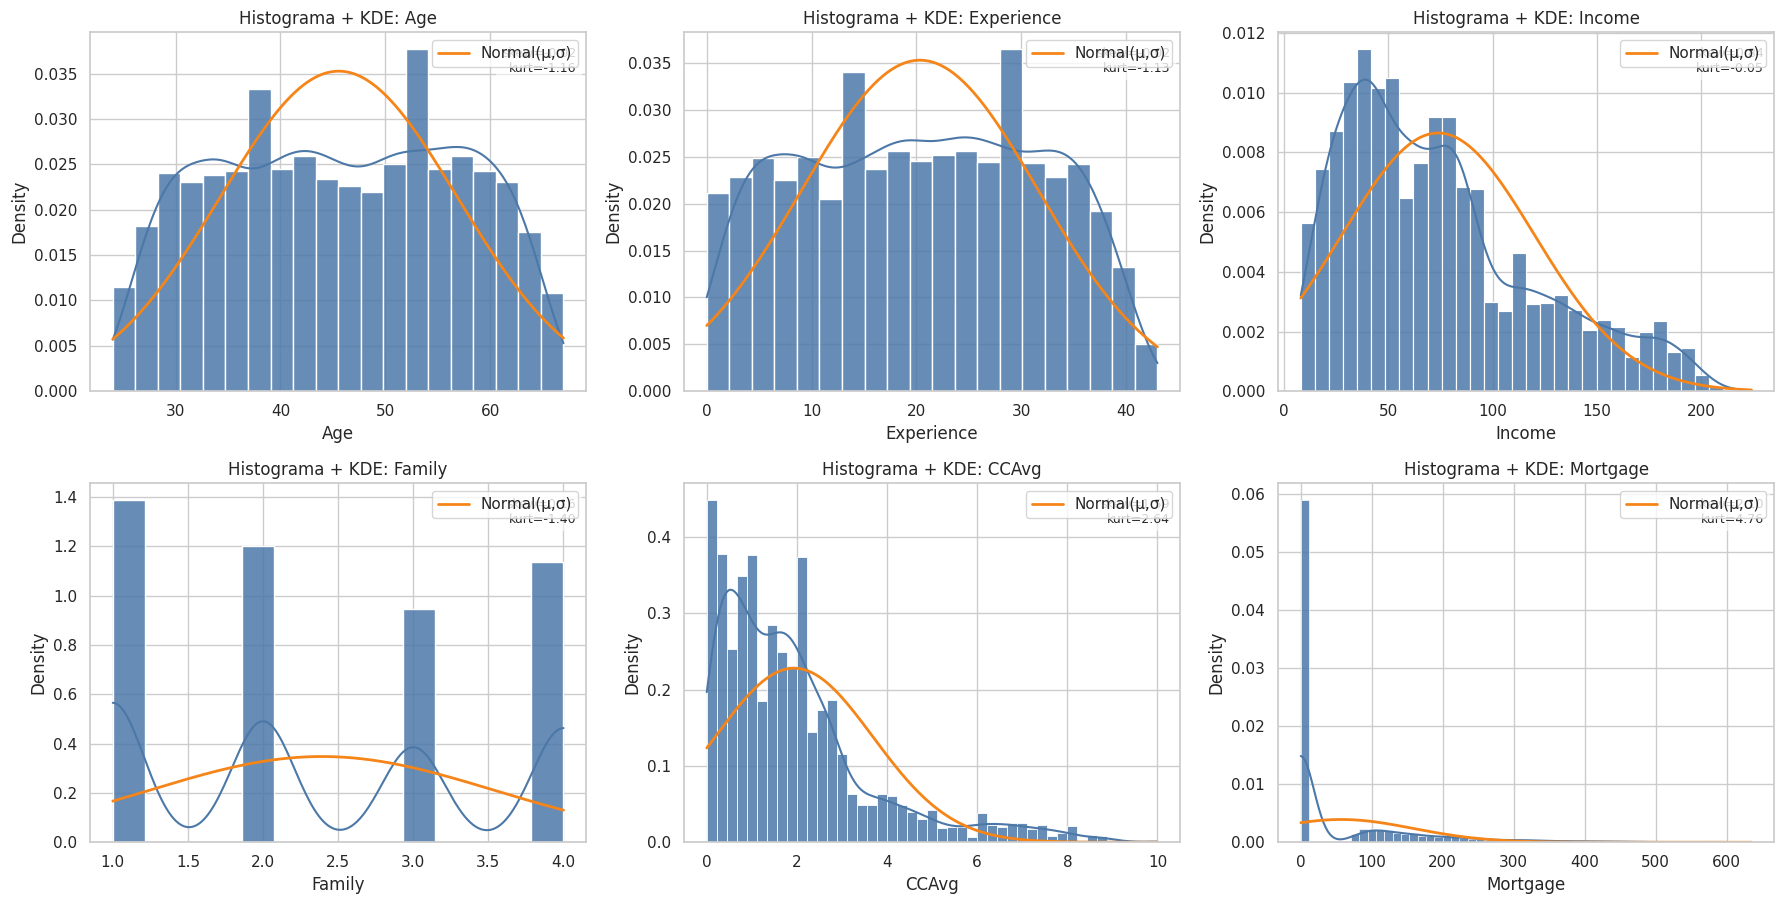


=== Comentario de forma esperado vs. histogramas ===
• Age: skew=-0.02 (≈ simétrica), kurtosis=-1.16 (platicúrtica (colas ligeras)). Visualmente debería observarse forma aproximadamente simétrica, pico más bajo/colas ligeras (platicúrtica).
• Income: skew=0.84 (asimetría positiva moderada), kurtosis=-0.05 (mesocúrtica (≈ normal)). Visualmente debería observarse cola a la derecha (sesgo positivo), altura similar a normal (mesocúrtica).
• Mortgage: skew=2.10 (asimetría positiva alta), kurtosis=4.76 (leptocúrtica (colas pesadas)). Visualmente debería observarse cola a la derecha (sesgo positivo), pico más agudo/colas pesadas (leptocúrtica).


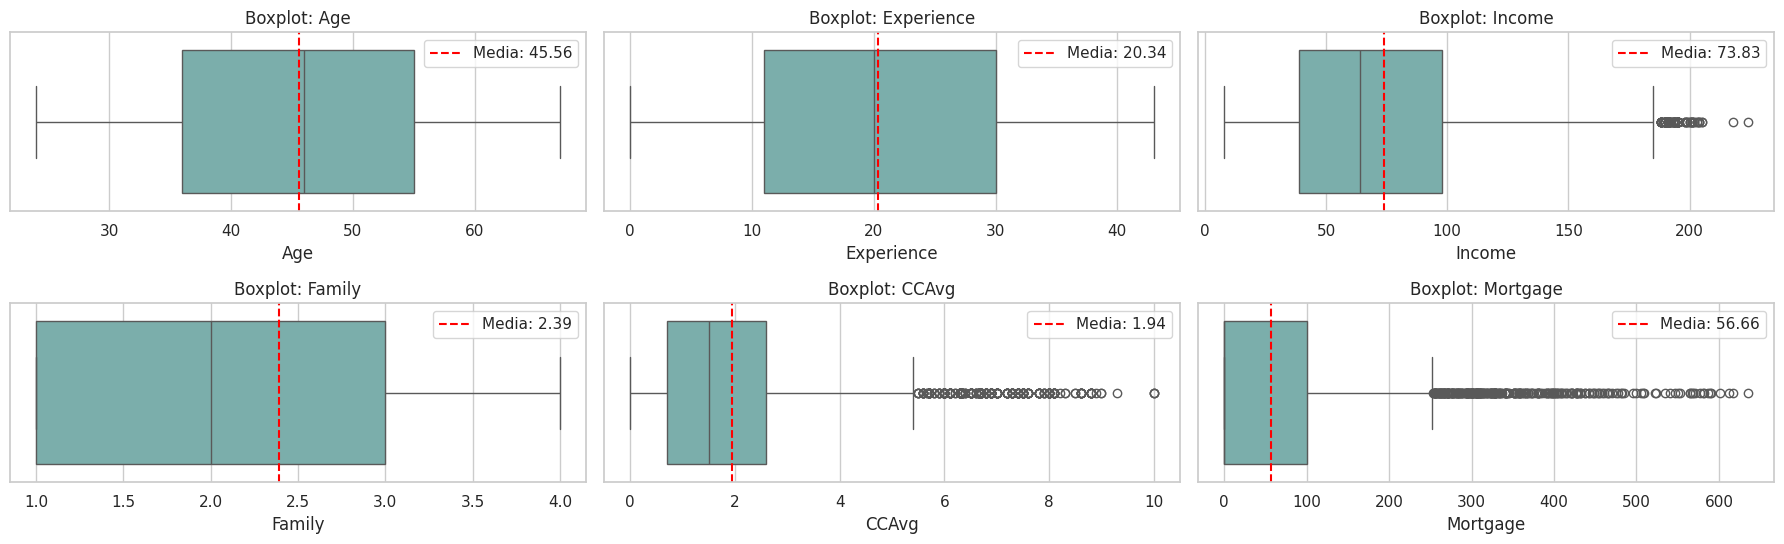


=== Media vs. Mediana (indicio de asimetría) ===
- Age: media=45.560, mediana=46.000 → media < mediana → sesgo negativo (cola izquierda)
- Experience: media=20.335, mediana=20.000 → media > mediana → sesgo positivo (cola derecha)
- Income: media=73.827, mediana=64.000 → media > mediana → sesgo positivo (cola derecha)
- Family: media=2.392, mediana=2.000 → media > mediana → sesgo positivo (cola derecha)
- CCAvg: media=1.936, mediana=1.500 → media > mediana → sesgo positivo (cola derecha)
- Mortgage: media=56.664, mediana=0.000 → media > mediana → sesgo positivo (cola derecha)


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import math

sns.set(style='whitegrid', context='notebook')

num_cols = [c for c in loan_df.columns if str(loan_df[c].dtype) in {'int64', 'float64'}]
if 'ID' in num_cols:  # si existe, no la analizamos
    num_cols.remove('ID')

assert len(num_cols) > 0, "No se detectaron columnas numéricas."

desc = loan_df[num_cols].describe().T
skew = loan_df[num_cols].skew()
kurt = loan_df[num_cols].kurt()
summary_num = desc.copy()
summary_num['skewness'] = skew
summary_num['kurtosis'] = kurt

print("=== Estadísticas numéricas con asimetría y curtosis ===")
print(summary_num.round(3))

def clasifica_asimetria(s):
    if abs(s) < 0.5:
        return '≈ simétrica'
    if 0.5 <= s < 1:
        return 'asimetría positiva moderada' if s > 0 else 'asimetría negativa moderada'
    if abs(s) >= 1:
        return 'asimetría positiva alta' if s > 0 else 'asimetría negativa alta'

def clasifica_curtosis(k):
    if -0.5 <= k <= 0.5:
        return 'mesocúrtica (≈ normal)'
    elif k > 0.5:
        return 'leptocúrtica (colas pesadas)'
    else:
        return 'platicúrtica (colas ligeras)'

vars_a_clasificar = [v for v in ['Age','Income','Mortgage'] if v in summary_num.index]
print("\n=== Clasificación (Age, Income, Mortgage) ===")
for var in vars_a_clasificar:
    s = float(summary_num.loc[var, 'skewness'])
    k = float(summary_num.loc[var, 'kurtosis'])
    print(f"- {var}: skew={s:.3f} → {clasifica_asimetria(s)}; kurtosis={k:.3f} → {clasifica_curtosis(k)}")

n = len(num_cols)
cols = 3
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.6*rows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(num_cols):
    ax = axes[i]
    data = loan_df[col].dropna()

    sns.histplot(data, kde=True, stat='density', bins='auto',
                 color='#4C78A8', edgecolor='white', ax=ax, alpha=0.85)

    mu, sigma = data.mean(), data.std(ddof=0)
    if sigma > 0:
        x = np.linspace(data.min(), data.max(), 400)
        y = norm.pdf(x, mu, sigma)
        ax.plot(x, y, color='#F58518', lw=2, label='Normal(μ,σ)')


    sk = data.skew()
    ku = data.kurt()
    ax.set_title(f'Histograma + KDE: {col}')
    ax.legend(loc='upper right')
    ax.text(0.98, 0.96, f"skew={sk:.2f}\nkurt={ku:.2f}",
            transform=ax.transAxes, ha='right', va='top',
            fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

def comentario_forma(var):
    if var not in num_cols:
        return f"{var}: no encontrada."
    s = float(summary_num.loc[var, 'skewness'])
    k = float(summary_num.loc[var, 'kurtosis'])
    desc_s = clasifica_asimetria(s)
    desc_k = clasifica_curtosis(k)
    esperado = []
    if abs(s) < 0.5:
        esperado.append("forma aproximadamente simétrica")
    elif s > 0:
        esperado.append("cola a la derecha (sesgo positivo)")
    else:
        esperado.append("cola a la izquierda (sesgo negativo)")

    if -0.5 <= k <= 0.5:
        esperado.append("altura similar a normal (mesocúrtica)")
    elif k > 0.5:
        esperado.append("pico más agudo/colas pesadas (leptocúrtica)")
    else:
        esperado.append("pico más bajo/colas ligeras (platicúrtica)")

    return (f"{var}: skew={s:.2f} ({desc_s}), kurtosis={k:.2f} ({desc_k}). "
            f"Visualmente debería observarse {', '.join(esperado)}.")

print("\n=== Comentario de forma esperado vs. histogramas ===")
for var in vars_a_clasificar:
    print("• " + comentario_forma(var))

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 2.8*rows))
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(x=loan_df[col], ax=ax, color='#72B7B2')
    mean_val = loan_df[col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', lw=1.5, label=f'Media: {mean_val:.2f}')
    ax.set_title(f'Boxplot: {col}')
    ax.legend(loc='upper right')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

print("\n=== Media vs. Mediana (indicio de asimetría) ===")
for col in num_cols:
    mean_v = float(loan_df[col].mean())
    med_v  = float(loan_df[col].median())
    if abs(mean_v - med_v) < 1e-9:
        rel = "≈ iguales (simetría)"
        sesgo = "≈ simétrica"
    elif mean_v > med_v:
        rel = "media > mediana"
        sesgo = "sesgo positivo (cola derecha)"
    else:
        rel = "media < mediana"
        sesgo = "sesgo negativo (cola izquierda)"
    print(f"- {col}: media={mean_v:.3f}, mediana={med_v:.3f} → {rel} → {sesgo}")

8. Obtén las estadísticas descriptivas de las variables categóricas.
* Genera un gráfico de barras para cada variable. En las de alta cardinalidad, sólo incluye los 10 valores más relevantes.

Columnas categóricas detectadas: ['ZIP Code', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

===== Frecuencias en 'ZIP Code' =====
(Alta cardinalidad) Top 10 categorías:
ZIP Code
94720    163
94305    123
95616    115
90095     71
93106     56
93943     54
92037     54
91320     53
94025     52
91711     51
Name: count, dtype: Int64

===== Frecuencias en 'Education' =====
Education
1    2079
3    1477
2    1385
Name: count, dtype: Int64

===== Frecuencias en 'Personal Loan' =====
Personal Loan
0    4462
1     479
Name: count, dtype: Int64

===== Frecuencias en 'Securities Account' =====
Securities Account
0    4426
1     515
Name: count, dtype: Int64

===== Frecuencias en 'CD Account' =====
CD Account
0    4640
1     301
Name: count, dtype: Int64

===== Frecuencias en 'Online' =====
Online
1    2951
0    1990
Name: count, dtype: Int64

===== Frecuencias en 'CreditCard' =====
CreditCard
0    3489
1    1452
Name: count, dtype: Int64

=== Resume

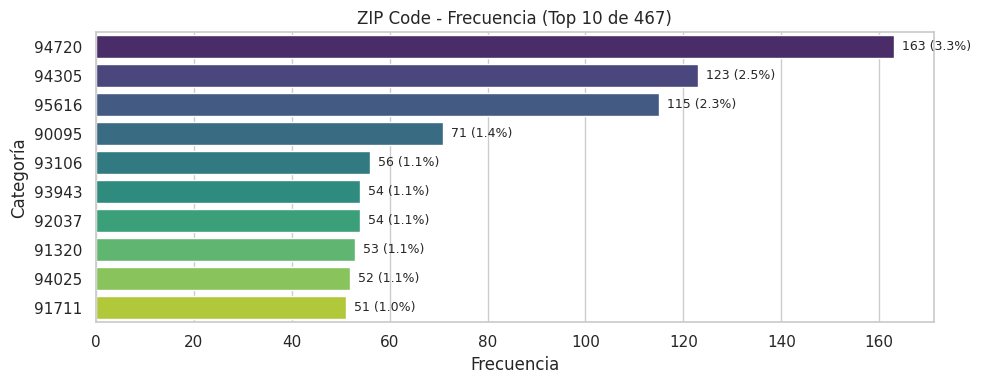

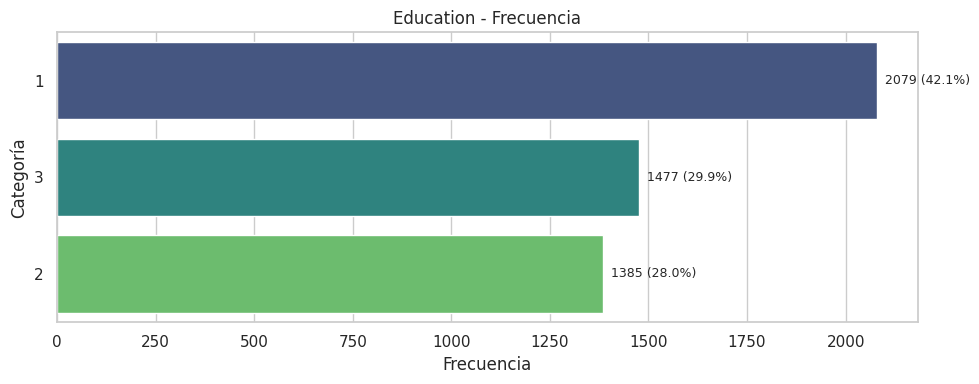

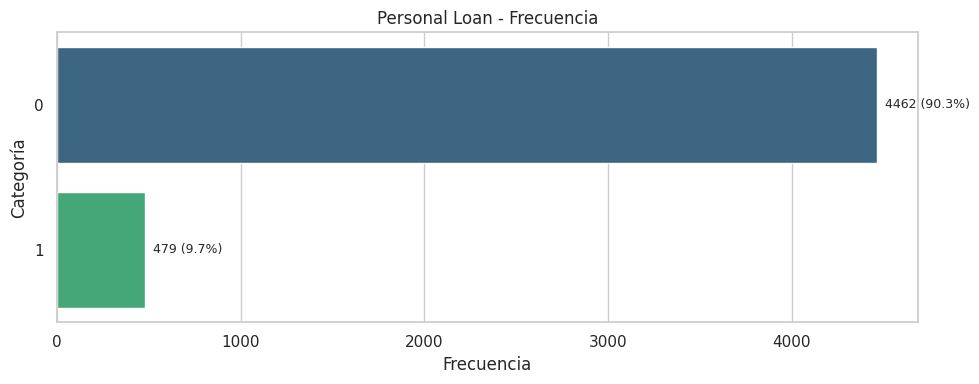

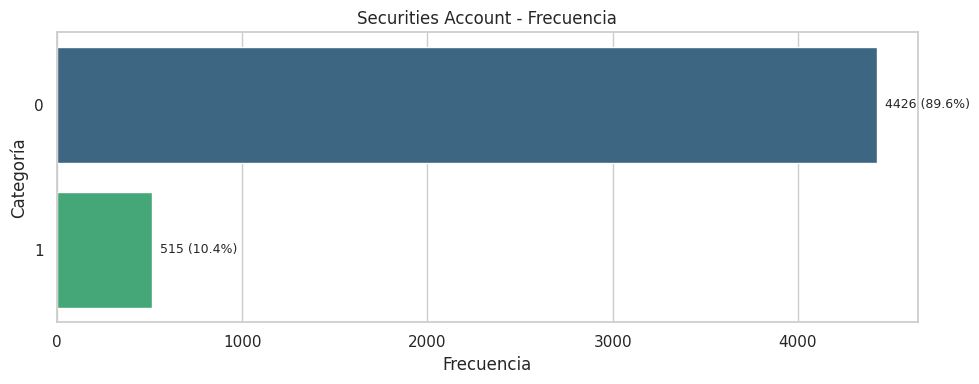

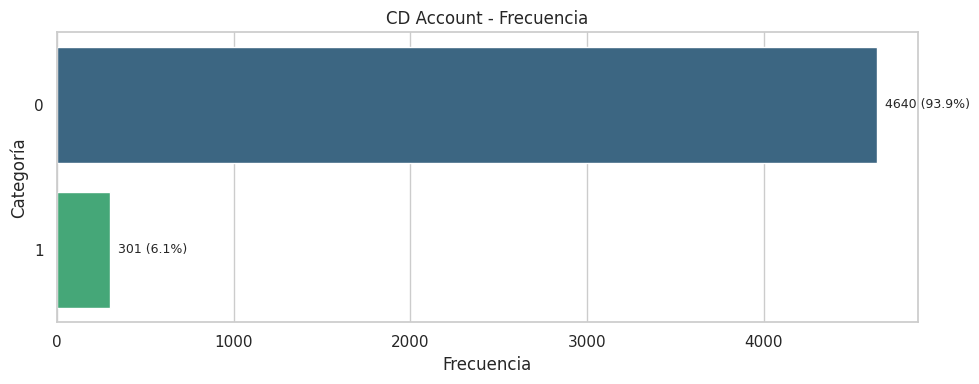

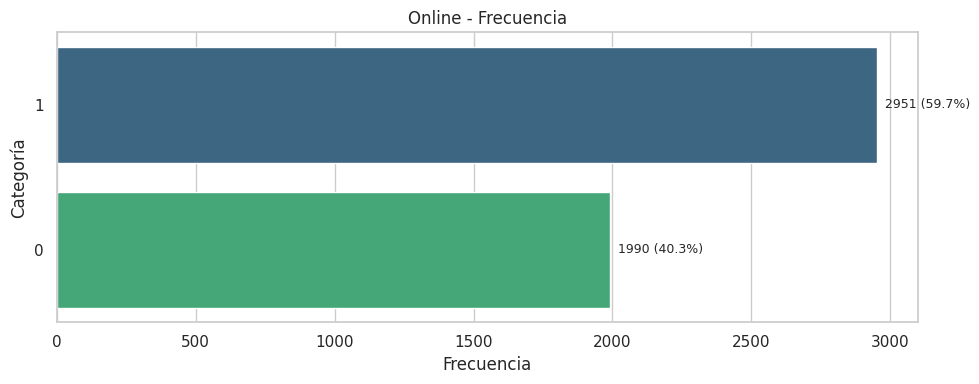

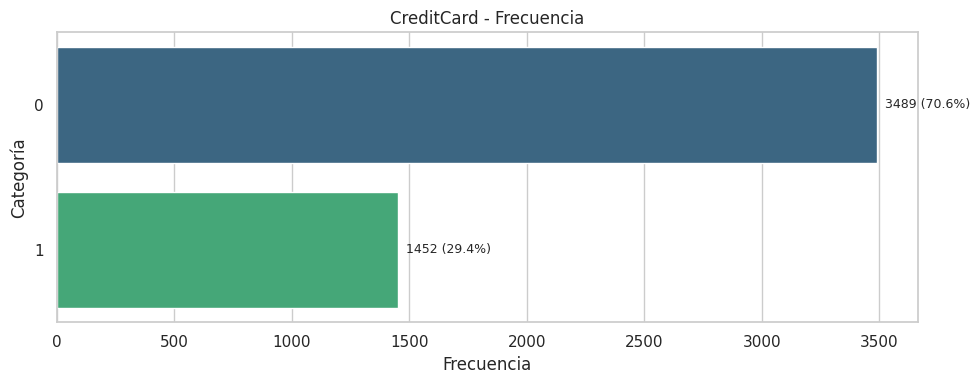

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, os

sns.set(style='whitegrid', context='notebook')

cat_cols = loan_df.select_dtypes(include=['object', 'category']).columns.tolist()
assert len(cat_cols) > 0, "No se detectaron columnas categóricas (object/category)."

print("Columnas categóricas detectadas:", cat_cols)

resumen = []
all_freq_records = []

for c in cat_cols:
    s = loan_df[c].astype('string')
    s_stripped = s.str.strip()

    vc = s_stripped.value_counts(dropna=False)
    vc_no_na = s_stripped.dropna().value_counts()

    n_unique = s_stripped.nunique(dropna=True)
    top = vc_no_na.index[0] if not vc_no_na.empty else pd.NA
    freq_top = int(vc_no_na.iloc[0]) if not vc_no_na.empty else 0
    missing = int(s_stripped.isna().sum())

    resumen.append({
        'columna': c,
        'n_unique': n_unique,
        'top': top,
        'freq_top': freq_top,
        'missing': missing
    })

    print(f"\n===== Frecuencias en '{c}' =====")
    if n_unique > 10:
        print("(Alta cardinalidad) Top 10 categorías:")
        print(vc_no_na.head(10))
    else:

        print(vc_no_na)

    denom = max(vc_no_na.sum(), 1)
    for cat_val, cnt in vc_no_na.items():
        all_freq_records.append({
            'variable': c,
            'categoria': cat_val,
            'count': int(cnt),
            'pct': float(cnt / denom)
        })

# Tabla resumen de categóricas
summary_cats = pd.DataFrame(resumen).sort_values('columna')
print("\n=== Resumen descriptivo (categóricas) ===")
print(summary_cats)

# (Opcional) Exportar frecuencias en formato largo
freq_long_df = pd.DataFrame(all_freq_records)
# freq_long_df.to_csv('categorical_frequencies_long.csv', index=False)

# ------------------------------------------------
# 3) Gráficos de barras por variable
#    - Para alta cardinalidad (>10) graficar sólo Top 10
#    - Barras horizontales para legibilidad
#    - Se anotan conteos y % (respecto a no-NA)
# ------------------------------------------------
save_figs = False                # Cambia a True si quieres guardar los PNG
out_dir = "fig_categoricas"      # Carpeta de salida si save_figs=True
top_k = 10

if save_figs and not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

for c in cat_cols:
    s = loan_df[c].astype('string').str.strip()
    vc_no_na = s.dropna().value_counts()
    n_unique = vc_no_na.shape[0]

    data_to_plot = vc_no_na.head(top_k) if n_unique > top_k else vc_no_na
    denom = max(vc_no_na.sum(), 1)
    pct_vals = (data_to_plot / denom * 100).round(2)

    plt.figure(figsize=(10, max(4, 0.4 * len(data_to_plot))))
    ax = sns.barplot(x=data_to_plot.values, y=data_to_plot.index.astype(str),
                     palette='viridis')

    ttl = f"{c} - Frecuencia"
    if n_unique > top_k:
        ttl += f" (Top {top_k} de {n_unique})"
    plt.title(ttl)
    plt.xlabel("Frecuencia")
    plt.ylabel("Categoría")

    for i, (cnt, pct) in enumerate(zip(data_to_plot.values, pct_vals.values)):
        ax.text(cnt, i, f"  {cnt} ({pct:.1f}%)",
                va='center', ha='left', fontsize=9)

    plt.tight_layout()

    if save_figs:
        fname = f"{out_dir}/bar_{c.replace(' ','_')}.png"
        plt.savefig(fname, dpi=140)
        print(f"Figura guardada: {fname}")

    plt.show()



# Análisis exploratorio de datos (bivariado)

9. Obtén la matriz de gráficos de dispersión (*scatter matrix*) de todas las variables numéricas.
* Observa las relaciones entre las variables, selecciona un par representativo y describe los patrones o tendencias que sean evidentes.
* Para cuantificar la fuerza y dirección de las relaciones observadas, genera un mapa de calor con los valores de correlación de *Pearson*. ¿El valor numérico obtenido del par seleccionado se corresponde con lo esperado?

<Figure size 1200x1200 with 0 Axes>

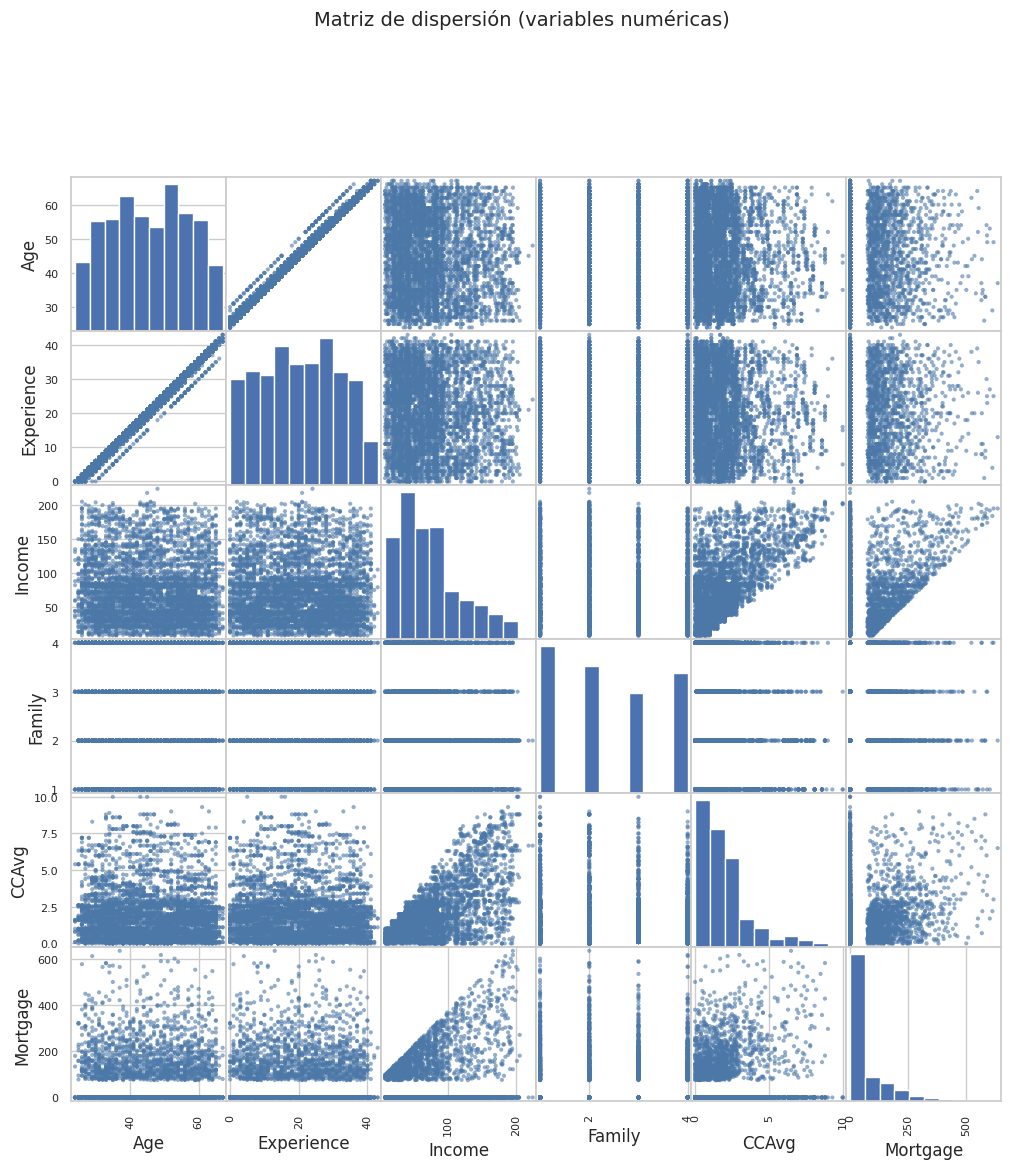

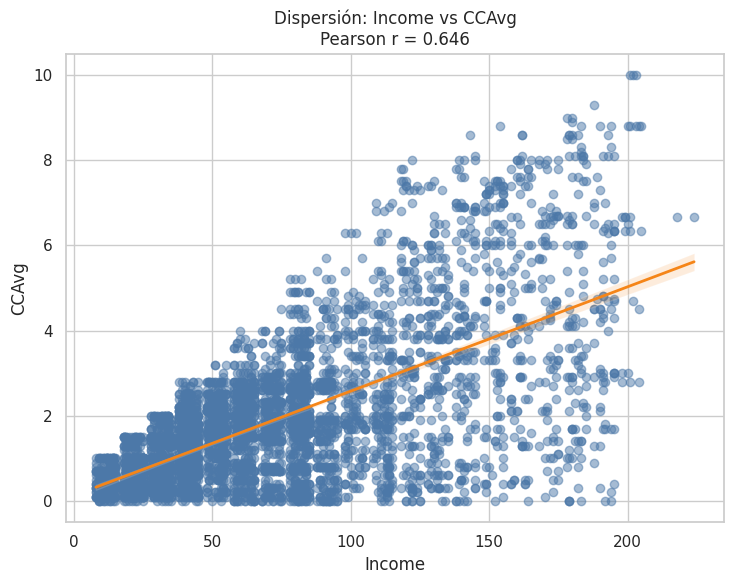

=== Par representativo seleccionado ===
- Par: (Income, CCAvg)
- Pearson r = 0.646
- Descripción: Relación positiva fuerte (r = 0.646). Tendencia aproximadamente lineal es visible en la nube de puntos.


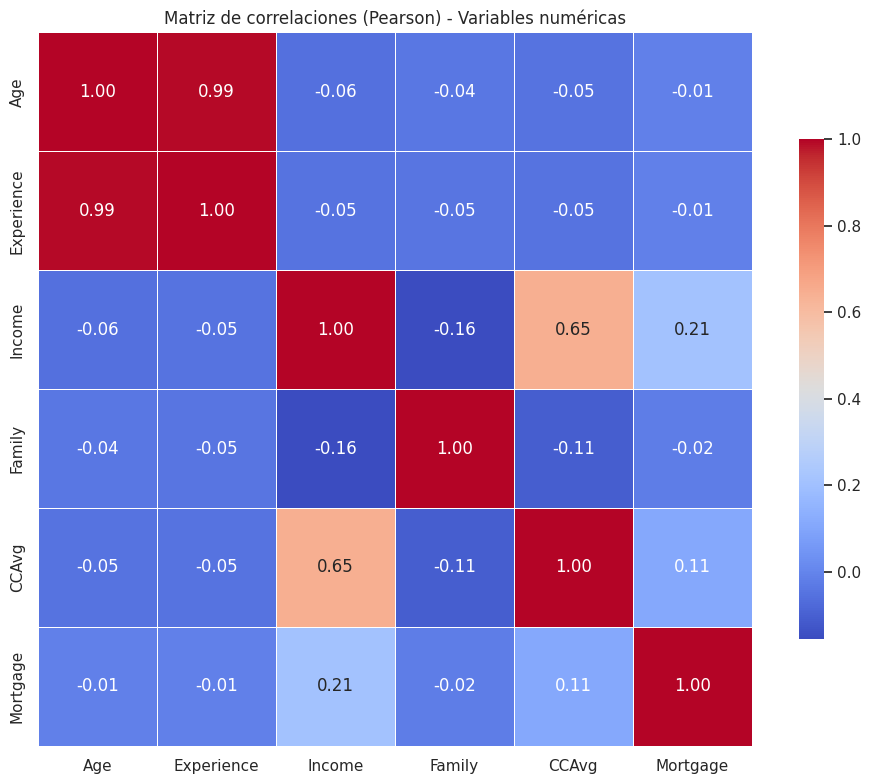


=== Verificación con lo esperado ===
- Pendiente estimada (recta de regresión): 0.0245
- Coincidencia visual vs. r: Sí, el valor de Pearson coincide con la tendencia observada (signo y fuerza consistentes).


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

sns.set(style='whitegrid', context='notebook')

num_cols = [c for c in loan_df.columns if pd.api.types.is_numeric_dtype(loan_df[c])]
if 'ID' in num_cols:
    num_cols.remove('ID')

assert len(num_cols) >= 2, "Se requieren al menos 2 variables numéricas para el análisis bivariado."

fig = plt.figure(figsize=(12, 12))
axs = scatter_matrix(loan_df[num_cols], figsize=(12, 12), diagonal='hist', color='#4C78A8', alpha=0.6)
plt.suptitle('Matriz de dispersión (variables numéricas)', y=1.02, fontsize=14)
plt.show()

corr = loan_df[num_cols].corr(method='pearson')

candidate_pair = None
if {'Income', 'CCAvg'}.issubset(num_cols):
    candidate_pair = ('Income', 'CCAvg')
else:
    cm = corr.copy()
    np.fill_diagonal(cm.values, np.nan)
    pair_idx = cm.abs().unstack().dropna()
    pair_idx = pair_idx[pair_idx.index.get_level_values(0) < pair_idx.index.get_level_values(1)]
    candidate_pair = pair_idx.idxmax()

x_var, y_var = candidate_pair
pearson_val = float(corr.loc[x_var, y_var])

plt.figure(figsize=(7.5, 6))
ax = sns.regplot(data=loan_df, x=x_var, y=y_var,
                 scatter_kws={'alpha':0.5, 'color':'#4C78A8'},
                 line_kws={'color':'#F58518', 'lw':2})
plt.title(f'Dispersión: {x_var} vs {y_var}\nPearson r = {pearson_val:.3f}')
plt.xlabel(x_var); plt.ylabel(y_var)
plt.tight_layout()
plt.show()

def describe_corr(r):
    ar = abs(r)
    if ar < 0.2:  strength = 'muy débil'
    elif ar < 0.4: strength = 'débil'
    elif ar < 0.6: strength = 'moderada'
    elif ar < 0.8: strength = 'fuerte'
    else:          strength = 'muy fuerte'
    direction = 'positiva' if r > 0 else ('negativa' if r < 0 else 'nula')
    base = f"Relación {direction} {strength} (r = {r:.3f})."
    if ar >= 0.4:
        base += " Tendencia aproximadamente lineal es visible en la nube de puntos."
    else:
        base += " La nube de puntos muestra alta dispersión y patrón poco definido."
    return base

print("=== Par representativo seleccionado ===")
print(f"- Par: ({x_var}, {y_var})")
print(f"- Pearson r = {pearson_val:.3f}")
print(f"- Descripción: {describe_corr(pearson_val)}")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, cbar_kws={'shrink': 0.7}, linewidths=0.5)
plt.title('Matriz de correlaciones (Pearson) - Variables numéricas')
plt.tight_layout()
plt.show()

x = loan_df[x_var].values
y = loan_df[y_var].values

coef = np.polyfit(x[~np.isnan(x) & ~np.isnan(y)], y[~np.isnan(x) & ~np.isnan(y)], 1)[0]
sign_match = (pearson_val == 0 and abs(coef) < 1e-9) or (pearson_val * coef > 0)
msg_match = "Sí, el valor de Pearson coincide con la tendencia observada (signo y fuerza consistentes)." if sign_match \
            else "Parcialmente: el signo o la fuerza no parecen coincidir visualmente."
print("\n=== Verificación con lo esperado ===")
print(f"- Pendiente estimada (recta de regresión): {coef:.4f}")
print(f"- Coincidencia visual vs. r: {msg_match}")

10. Realiza un análisis de todas las variables del dataset con respecto a la variable de salida `Personal Loan`.
* Variables numéricas: Genera box plots para comparar la distribución de cada variable según los valores de `Personal Loan`.
* Variables categóricas (sin considerar `ZIP Code`): Genera gráficos de barras apiladas que muestren la distribución relativa de `Personal Loan` dentro de cada categoría de la variable.
* Para cada grupo de variables (numéricas y categóricas), comenta al menos un hallazgo o patrón relevante observado en los gráficos generados.


Dataset para bivariado: 4941 filas con 'Personal Loan' en {0,1}.
Numéricas: ['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']
Categóricas (sin ZIP Code): ['Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


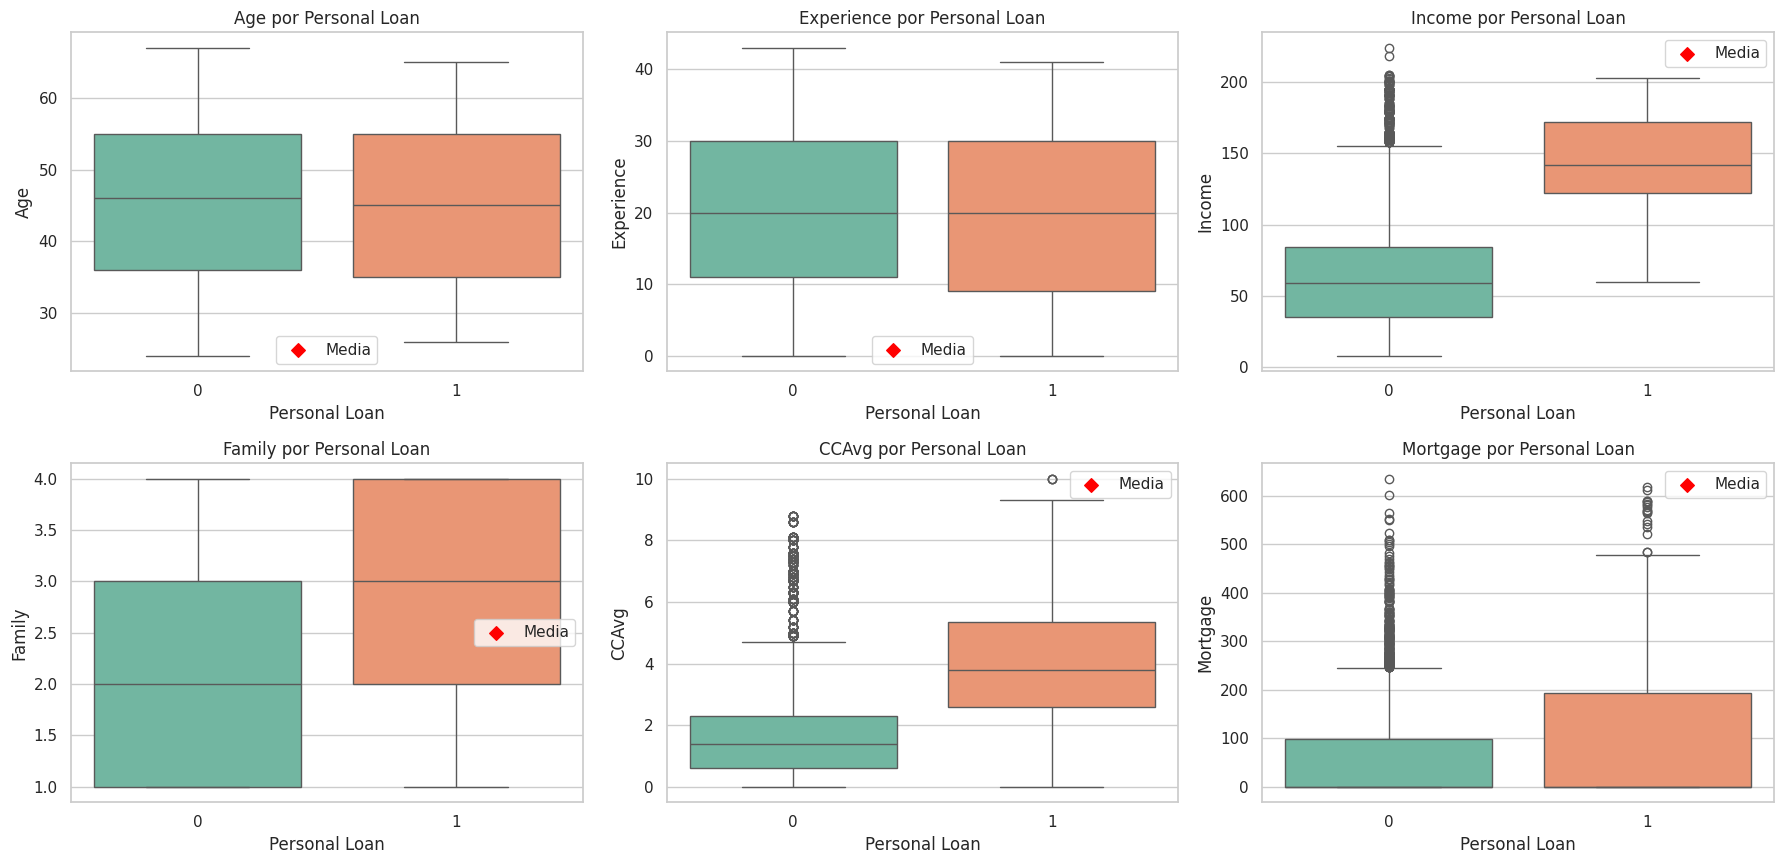

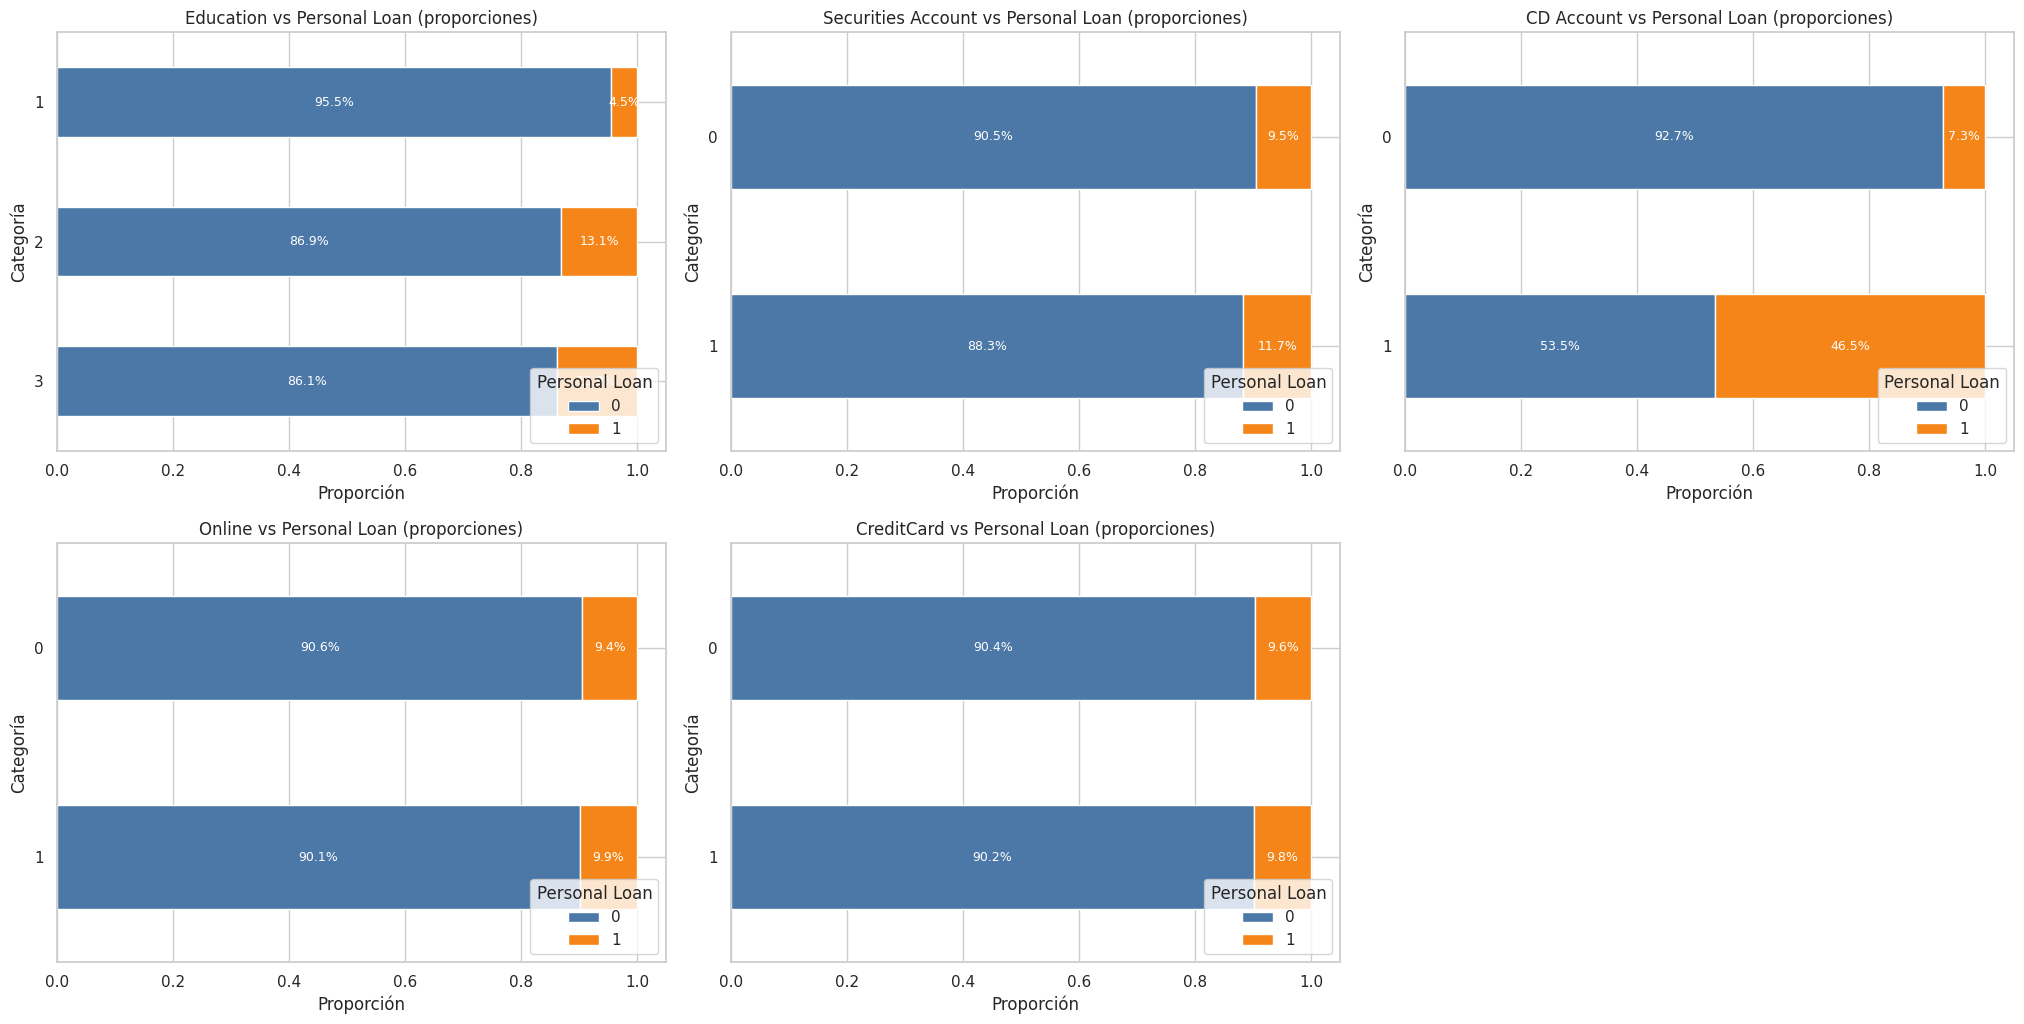


=== Hallazgos==

[Numéricas] Variables con mayor separación de mediana (PL=1 vs PL=0):
Personal Loan  delta_median
Income                 83.0
CCAvg                   2.4
Family                  1.0
Age                    -1.0
Experience              0.0
• Income: mediana mayor cuando PL=1 (Δ≈ 83.00).
• CCAvg: mediana mayor cuando PL=1 (Δ≈ 2.40).
• Family: mediana mayor cuando PL=1 (Δ≈ 1.00).

[Categóricas] Variables con mayor dispersión de tasa de préstamo entre categorías:
             variable  spread (pp)
0          CD Account         39.2
1           Education          9.4
2  Securities Account          2.2
3              Online          0.4
4          CreditCard          0.2

Comentarios por variable (top contrastes):
• Education: mayor tasa en '3' (13.9%), menor en '1' (4.5%). Δ=9.4 pp
• Securities Account: mayor tasa en '1' (11.7%), menor en '0' (9.5%). Δ=2.2 pp
• CD Account: mayor tasa en '1' (46.5%), menor en '0' (7.3%). Δ=39.2 pp
• Online: mayor tasa en '1' (9.9%), menor en

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, os, warnings

warnings.filterwarnings("ignore")
sns.set(style='whitegrid', context='notebook')

assert 'Personal Loan' in loan_df.columns, "No se encontró la columna 'Personal Loan'."

def to_binary(x):
    if pd.isna(x): return np.nan
    t = str(x).strip().lower()
    truthy = {'1','yes','y','si','sí','true','t'}
    falsy  = {'0','no','n','false','f'}
    if t in truthy: return 1
    if t in falsy:  return 0

    try:
        v = float(t)
        if v in (0.0, 1.0): return int(v)
    except:
        pass
    return np.nan

pl_tmp = loan_df['Personal Loan'].map(to_binary)

loan_df = loan_df[pl_tmp.isin([0,1])].copy()
loan_df['Personal Loan'] = pl_tmp.astype('int').astype('category')

print(f"Dataset para bivariado: {loan_df.shape[0]} filas con 'Personal Loan' en {{0,1}}.")

num_cols = [c for c in loan_df.columns
            if pd.api.types.is_numeric_dtype(loan_df[c]) and c not in ['ID'] and c != 'Personal Loan']
cat_cols = [c for c in loan_df.columns
            if loan_df[c].dtype.name in ['object','category'] and c not in ['Personal Loan']]
cat_no_zip = [c for c in cat_cols if c != 'ZIP Code']

print("Numéricas:", num_cols)
print("Categóricas (sin ZIP Code):", cat_no_zip)

if len(num_cols) > 0:
    cols = 3
    rows = math.ceil(len(num_cols) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4.4*rows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.boxplot(x='Personal Loan', y=col, data=loan_df, ax=ax, palette='Set2')
        # Medias por grupo (PL=0/1)
        grp_means = loan_df.groupby('Personal Loan')[col].mean()
        for j, (pl_val, mean_v) in enumerate(grp_means.items()):
            ax.scatter(j, mean_v, color='red', marker='D', s=48,
                       label='Media' if j == 0 else None)
        ax.set_title(f'{col} por Personal Loan')
        ax.legend(loc='best')

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas numéricas para graficar.")

if len(cat_no_zip) > 0:
    cols = 3
    rows = math.ceil(len(cat_no_zip) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(6.8*cols, 5.2*rows))
    axes = np.atleast_1d(axes).ravel()

    for i, c in enumerate(cat_no_zip):
        ax = axes[i]
        tab = pd.crosstab(loan_df[c].astype(str), loan_df['Personal Loan'].astype(int), normalize='index')

        if 1 in tab.columns:
            tab = tab.sort_values(by=1, ascending=False)

        for col_miss in [0,1]:
            if col_miss not in tab.columns:
                tab[col_miss] = 0.0
        tab = tab[[0,1]]

        tab.plot(kind='barh', stacked=True, ax=ax, color=['#4C78A8','#F58518'], edgecolor='white')
        ax.set_title(f'{c} vs Personal Loan (proporciones)')
        ax.set_xlabel('Proporción'); ax.set_ylabel('Categoría')
        ax.legend(title='Personal Loan', loc='lower right')

        for yi, (idx, row) in enumerate(tab.iterrows()):
            left = 0.0
            for k, val in enumerate([row[0], row[1]]):
                if val > 0.04:
                    ax.text(left + val/2, yi, f"{val*100:.1f}%",
                            va='center', ha='center', color='white', fontsize=9)
                left += val

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas categóricas (excluyendo ZIP Code).")

print("\n=== Hallazgos==")

if len(num_cols) > 0:
    med = loan_df.groupby('Personal Loan')[num_cols].median().T

    if set(loan_df['Personal Loan'].cat.categories) == {0,1} or set(loan_df['Personal Loan'].unique()) == {0,1}:
        med['delta_median'] = med.get(1, np.nan) - med.get(0, np.nan)
        med['abs_delta'] = med['delta_median'].abs()
        med_sorted = med.sort_values('abs_delta', ascending=False)
        print("\n[Numéricas] Variables con mayor separación de mediana (PL=1 vs PL=0):")
        print(med_sorted[['delta_median']].head(5).round(3))
        # Comentario corto
        top_num = med_sorted.head(3)['delta_median']
        for var, delta in top_num.items():
            trend = "mayor" if delta > 0 else "menor"
            print(f"• {var}: mediana {trend} cuando PL=1 (Δ≈ {delta:.2f}).")
    else:
        print("\n[Numéricas] No hay ambas clases de PL para comparar medianas.")
else:
    print("\n[Numéricas] Sin variables para resumir.")

if len(cat_no_zip) > 0:
    print("\n[Categóricas] Variables con mayor dispersión de tasa de préstamo entre categorías:")
    dispersions = []
    top_cats_comments = []
    for c in cat_no_zip:
        rates = loan_df.groupby(c)['Personal Loan'].apply(lambda s: s.astype(int).mean())
        if len(rates) >= 2:
            spread = float(rates.max() - rates.min())
            dispersions.append((c, spread))

            top_cat = rates.idxmax(); top_val = float(rates.max())
            low_cat = rates.idxmin(); low_val = float(rates.min())
            top_cats_comments.append(
                f"• {c}: mayor tasa en '{top_cat}' ({top_val*100:.1f}%), menor en '{low_cat}' ({low_val*100:.1f}%). Δ={spread*100:.1f} pp"
            )
    if dispersions:
        dispersions = sorted(dispersions, key=lambda x: x[1], reverse=True)
        print(pd.DataFrame(dispersions, columns=['variable','spread_tasa']).head(5).assign(spread_tasa=lambda d: (d['spread_tasa']*100).round(1)).rename(columns={'spread_tasa':'spread (pp)'}))
        print("\nComentarios por variable (top contrastes):")
        for line in top_cats_comments[:5]:
            print(line)
    else:
        print("[Categóricas] No se pudo calcular la dispersión de tasas (¿una sola categoría?).")
else:
    print("\n[Categóricas] Sin variables para resumir.")